# **Waste Material Segregation for Improving Waste Management**

## **Objective**

The objective of this project is to implement an effective waste material segregation system using convolutional neural networks (CNNs) that categorises waste into distinct groups. This process enhances recycling efficiency, minimises environmental pollution, and promotes sustainable waste management practices.

The key goals are:

* Accurately classify waste materials into categories like cardboard, glass, paper, and plastic.
* Improve waste segregation efficiency to support recycling and reduce landfill waste.
* Understand the properties of different waste materials to optimise sorting methods for sustainability.

## **Data Understanding**

The Dataset consists of images of some common waste materials.

1. Food Waste
2. Metal
3. Paper
4. Plastic
5. Other
6. Cardboard
7. Glass


**Data Description**

* The dataset consists of multiple folders, each representing a specific class, such as `Cardboard`, `Food_Waste`, and `Metal`.
* Within each folder, there are images of objects that belong to that category.
* However, these items are not further subcategorised. <br> For instance, the `Food_Waste` folder may contain images of items like coffee grounds, teabags, and fruit peels, without explicitly stating that they are actually coffee grounds or teabags.

## **1. Load the data**

Load and unzip the dataset zip file.

**Import Necessary Libraries**

In [ ]:
# Recommended versions:

# numpy version: 1.26.4
# pandas version: 2.2.2
# seaborn version: 0.13.2
# matplotlib version: 3.10.0
# PIL version: 11.1.0
# tensorflow version: 2.18.0
# keras version: 3.8.0
# sklearn version: 1.6.1

In [32]:
# Import essential libraries

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import warnings
warnings.filterwarnings("ignore")

# Image handling
from PIL import Image

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Evaluation
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix


Load the dataset.

In [34]:
# Load and unzip the dataset
zip_path = "data.zip"
extract_path = "Waste_dataset"

# Unzip the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted to:", extract_path)


Dataset extracted to: Waste_dataset


## **2. Data Preparation** <font color=red> [25 marks] </font><br>


### **2.1 Load and Preprocess Images** <font color=red> [8 marks] </font><br>

Let us create a function to load the images first. We can then directly use this function while loading images of the different categories to load and crop them in a single step.

#### **2.1.1** <font color=red> [3 marks] </font><br>
Create a function to load the images.

Trying to access dataset at: Waste_dataset\data
Folder exists. Contents: ['Cardboard', 'Food_Waste', 'Glass', 'Metal', 'Other', 'Paper', 'Plastic']

Loading images from: Cardboard
Path: Waste_dataset\data\Cardboard
Successfully loaded 540 images from Cardboard

Loading images from: Food_Waste
Path: Waste_dataset\data\Food_Waste
Successfully loaded 1000 images from Food_Waste

Loading images from: Glass
Path: Waste_dataset\data\Glass
Successfully loaded 750 images from Glass

Loading images from: Metal
Path: Waste_dataset\data\Metal
Successfully loaded 1000 images from Metal

Loading images from: Other
Path: Waste_dataset\data\Other
Successfully loaded 1010 images from Other

Loading images from: Paper
Path: Waste_dataset\data\Paper
Successfully loaded 1030 images from Paper

Loading images from: Plastic
Path: Waste_dataset\data\Plastic
Successfully loaded 2295 images from Plastic

Successfully loaded 7625 images total

Dataset Summary:
Total images: 7625
Image shape: (128, 128, 3)
Clas

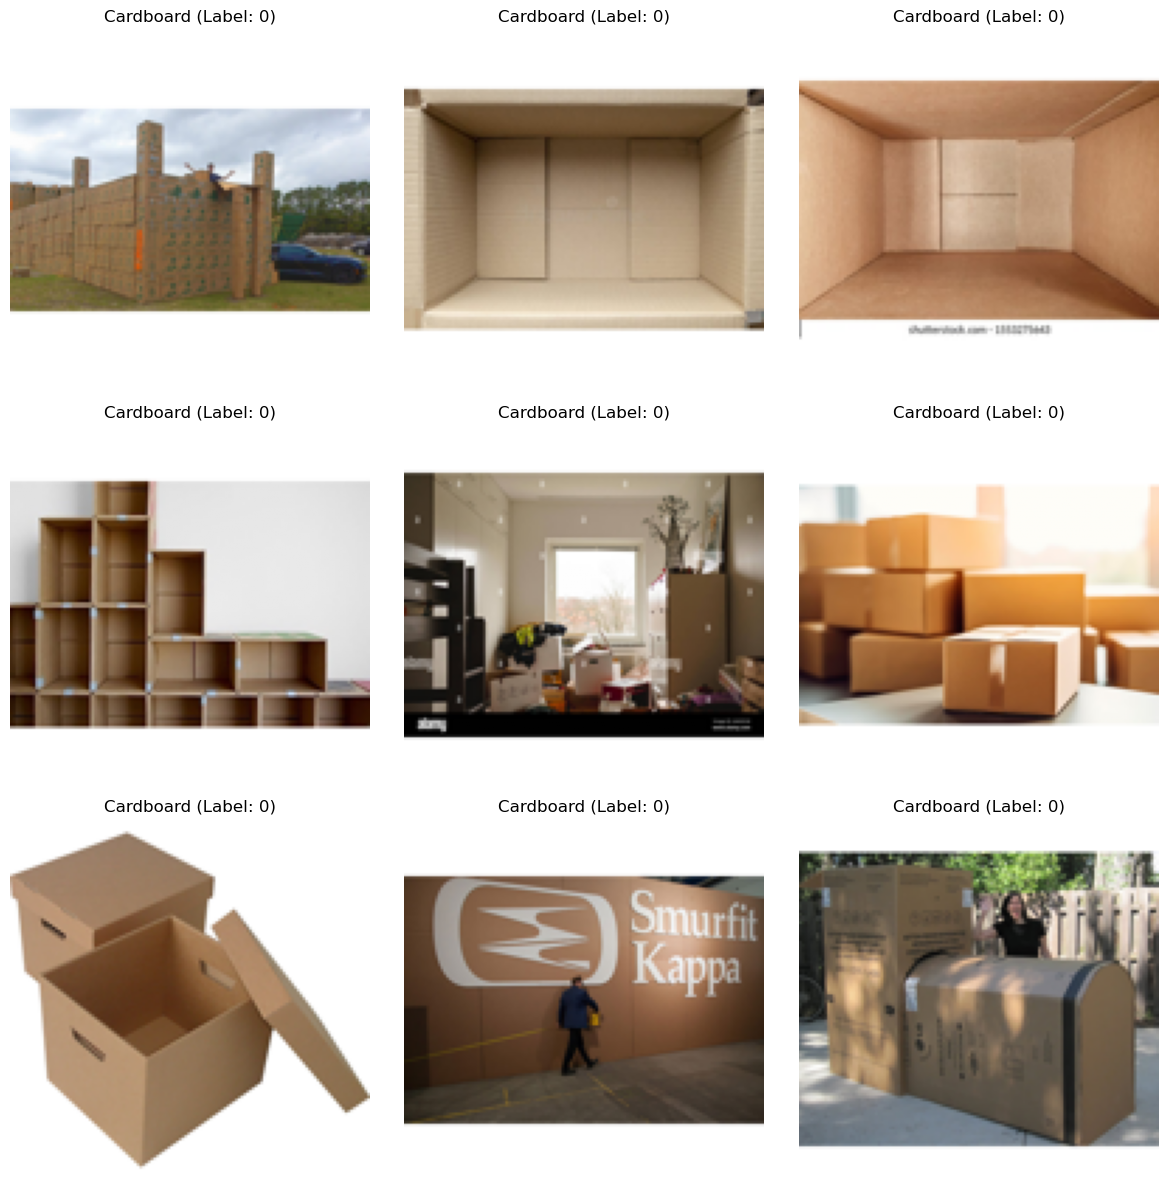

In [36]:
# Create a function to load the raw images
# First, let's properly set up the paths
base_path = "Waste_dataset"
data_folder = "data"

# Check if the data folder exists
dataset_path = os.path.join(base_path, data_folder)
print(f"Trying to access dataset at: {dataset_path}")

if not os.path.exists(dataset_path):
    print(f"Error: The path {dataset_path} does not exist.")
    print("Available directories:", os.listdir(base_path))
else:
    print("Folder exists. Contents:", os.listdir(dataset_path))

# Modified loading function with better permission handling
def load_raw_images(dataset_path, img_size=(128, 128)):
    """
    Load raw images from the dataset directory with proper permission handling.
    """
    images = []
    labels = []
    label_map = {}
    
    try:
        # Get all subdirectories (each represents a class)
        classes = sorted([d for d in os.listdir(dataset_path) 
                        if os.path.isdir(os.path.join(dataset_path, d))])
        
        if not classes:
            print("No class folders found.")
            return None, None, None
            
        # Create label mapping
        label_map = {class_name: idx for idx, class_name in enumerate(classes)}
        
        # Iterate through each class folder
        for class_name in classes:
            class_path = os.path.join(dataset_path, class_name)
            
            print(f"\nLoading images from: {class_name}")
            print(f"Path: {class_path}")
            
            # First check if we can access this directory
            if not os.access(class_path, os.R_OK):
                print(f"Warning: No read permission for {class_path}")
                continue
                
            # Get list of files with error handling
            try:
                img_files = os.listdir(class_path)
            except PermissionError:
                print(f"Permission denied for {class_path}")
                continue
                
            if not img_files:
                print(f"No images found in {class_name}")
                continue
                
            # Load images
            loaded_count = 0
            for img_file in img_files:
                img_path = os.path.join(class_path, img_file)
                
                try:
                    # Check file permissions first
                    if not os.access(img_path, os.R_OK):
                        print(f"Skipping {img_file} (no read permission)")
                        continue
                        
                    # Open and process the image
                    with Image.open(img_path) as img:
                        img = img.convert('RGB')
                        img = img.resize(img_size)
                        img_array = np.array(img) / 255.0
                        
                        images.append(img_array)
                        labels.append(label_map[class_name])
                        loaded_count += 1
                        
                except Exception as e:
                    print(f"Error processing {img_file}: {str(e)}")
            
            print(f"Successfully loaded {loaded_count} images from {class_name}")
            
    except Exception as e:
        print(f"Major error loading dataset: {str(e)}")
        return None, None, None
    
    if not images:
        print("\nNo images were loaded. Possible permission issues.")
        return None, None, None
    
    # Convert to numpy arrays
    images = np.array(images)
    labels = np.array(labels)
    
    print(f"\nSuccessfully loaded {len(images)} images total")
    return images, labels, label_map

# Try loading again with the correct path
images, labels, label_map = load_raw_images(dataset_path)

if images is not None:
    # Print dataset information
    print("\nDataset Summary:")
    print(f"Total images: {len(images)}")
    print(f"Image shape: {images[0].shape}")
    print(f"Classes: {label_map}")
    
    # Visualize samples
    plt.figure(figsize=(12, 12))
    for i in range(min(9, len(images))):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title(f"{list(label_map.keys())[labels[i]]} (Label: {labels[i]})")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("\nFailed to load images. Possible solutions:")
    print("1. Make sure you have read permissions for all files")
    print("2. Check if the files are not corrupted")
    print("3. Try moving the dataset to a different location (like your desktop)")
    print("4. Run your Python environment as administrator")

#### **2.1.2** <font color=red> [5 marks] </font><br>
Load images and labels.

Load the images from the dataset directory. Labels of images are present in the subdirectories.

Verify if the images and labels are loaded correctly.

Found classes: ['Cardboard', 'Food_Waste', 'Glass', 'Metal', 'Other', 'Paper', 'Plastic']

Loading Cardboard...

Loading Food_Waste...

Loading Glass...

Loading Metal...

Loading Other...

Loading Paper...

Loading Plastic...

=== Dataset Verification ===
Total images: 7625
Image shape: (128, 128, 3)
Classes: ['Cardboard', 'Food_Waste', 'Glass', 'Metal', 'Other', 'Paper', 'Plastic']
Label counts: {'Cardboard': 540, 'Food_Waste': 1000, 'Glass': 750, 'Metal': 1000, 'Other': 1010, 'Paper': 1030, 'Plastic': 2295}


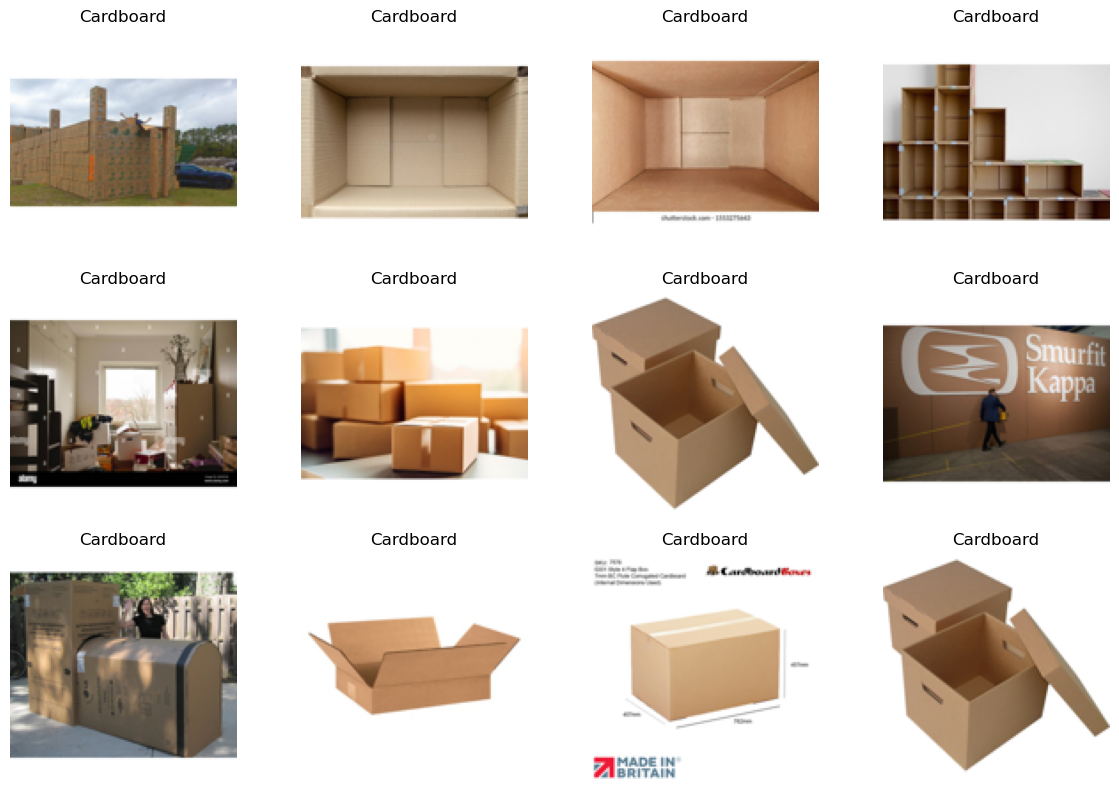

In [37]:
# Get the images and their labels

def load_images_and_labels(dataset_path, img_size=(128, 128)):
    """
    Load images and labels from subdirectories in the dataset path.
    
    Args:
        dataset_path (str): Path to the dataset directory
        img_size (tuple): Target size for resizing images
        
    Returns:
        tuple: (images, labels, class_names)
            images: Numpy array of image data
            labels: Numpy array of class labels
            class_names: List of class names
    """
    images = []
    labels = []
    class_names = []
    
    # Get list of classes (subdirectories)
    try:
        class_names = sorted([d for d in os.listdir(dataset_path) 
                           if os.path.isdir(os.path.join(dataset_path, d))])
    except FileNotFoundError:
        print(f"Error: Dataset path '{dataset_path}' not found")
        return None, None, None
    
    if not class_names:
        print("Error: No class directories found")
        return None, None, None
    
    print("Found classes:", class_names)
    
    # Load images from each class directory
    for label, class_name in enumerate(class_names):
        class_path = os.path.join(dataset_path, class_name)
        print(f"\nLoading {class_name}...")
        
        try:
            img_files = [f for f in os.listdir(class_path) 
                        if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        except PermissionError:
            print(f"Permission denied for {class_path}")
            continue
            
        for img_file in img_files:
            img_path = os.path.join(class_path, img_file)
            
            try:
                with Image.open(img_path) as img:
                    img = img.convert('RGB')
                    img = img.resize(img_size)
                    images.append(np.array(img) / 255.0)
                    labels.append(label)
            except Exception as e:
                print(f"Error loading {img_path}: {str(e)}")
    
    # Convert to numpy arrays
    return np.array(images), np.array(labels), class_names

# Load data (adjust path as needed)
dataset_path = os.path.join("Waste_dataset", "data")
images, labels, class_names = load_images_and_labels(dataset_path)

# Verification
if images is not None:
    print("\n=== Dataset Verification ===")
    print(f"Total images: {len(images)}")
    print(f"Image shape: {images[0].shape}")
    print(f"Classes: {class_names}")
    print("Label counts:", dict(zip(class_names, np.bincount(labels))))
    
    # Visual verification
    plt.figure(figsize=(12, 8))
    for i in range(min(12, len(images))):
        plt.subplot(3, 4, i+1)
        plt.imshow(images[i])
        plt.title(f"{class_names[labels[i]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("\nError: Failed to load dataset. Please check:")
    print(f"1. Path exists: {os.path.exists(dataset_path)}")
    if os.path.exists(dataset_path):
        print(f"2. Subdirectories: {os.listdir(dataset_path)}")
    print("3. File permissions")


Perform any operations, if needed, on the images and labels to get them into the desired format.

### **2.2 Data Visualisation** <font color=red> [9 marks] </font><br>

#### **2.2.1** <font color=red> [3 marks] </font><br>
Create a bar plot to display the class distribution

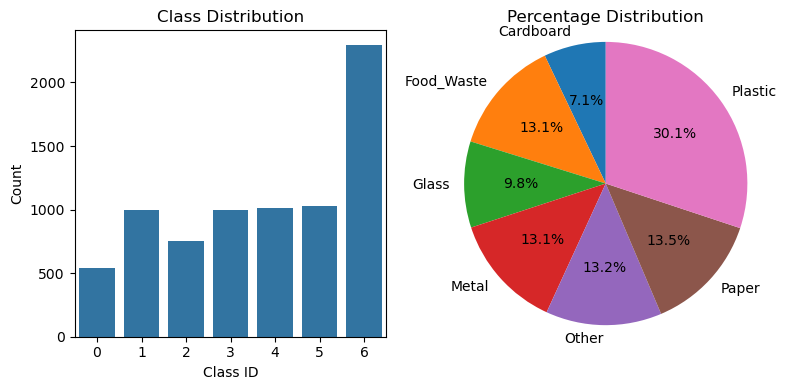


Class Distribution Details:
Cardboard: 540 images (7.1%)
Food_Waste: 1000 images (13.1%)
Glass: 750 images (9.8%)
Metal: 1000 images (13.1%)
Other: 1010 images (13.2%)
Paper: 1030 images (13.5%)
Plastic: 2295 images (30.1%)


In [40]:
# Visualise Data Distribution

def visualize_data_distribution(labels, class_names):
    """
    Visualize the distribution of images across different classes
    
    Args:
        labels: Array of class labels
        class_names: List of class names corresponding to labels
    """
    plt.figure(figsize=(8, 4))
    
    # Create count plot
    plt.subplot(1, 2, 1)
    sns.countplot(x=labels)
    plt.title('Class Distribution')
    plt.xlabel('Class ID')
    plt.ylabel('Count')
    
    # Create pie chart
    plt.subplot(1, 2, 2)
    counts = np.bincount(labels)
    plt.pie(counts, labels=class_names, autopct='%1.1f%%', startangle=90)
    plt.title('Percentage Distribution')
    plt.axis('equal')  # Equal aspect ratio ensures pie is drawn as a circle
    
    plt.tight_layout()
    plt.show()
    
    # Print numerical distribution
    print("\nClass Distribution Details:")
    for class_name, count in zip(class_names, counts):
        print(f"{class_name}: {count} images ({count/len(labels):.1%})")

# Visualize the distribution
if images is not None:
    visualize_data_distribution(labels, class_names)
else:
    print("Cannot visualize distribution - no data loaded")


#### **2.2.2** <font color=red> [3 marks] </font><br>
Visualise some sample images

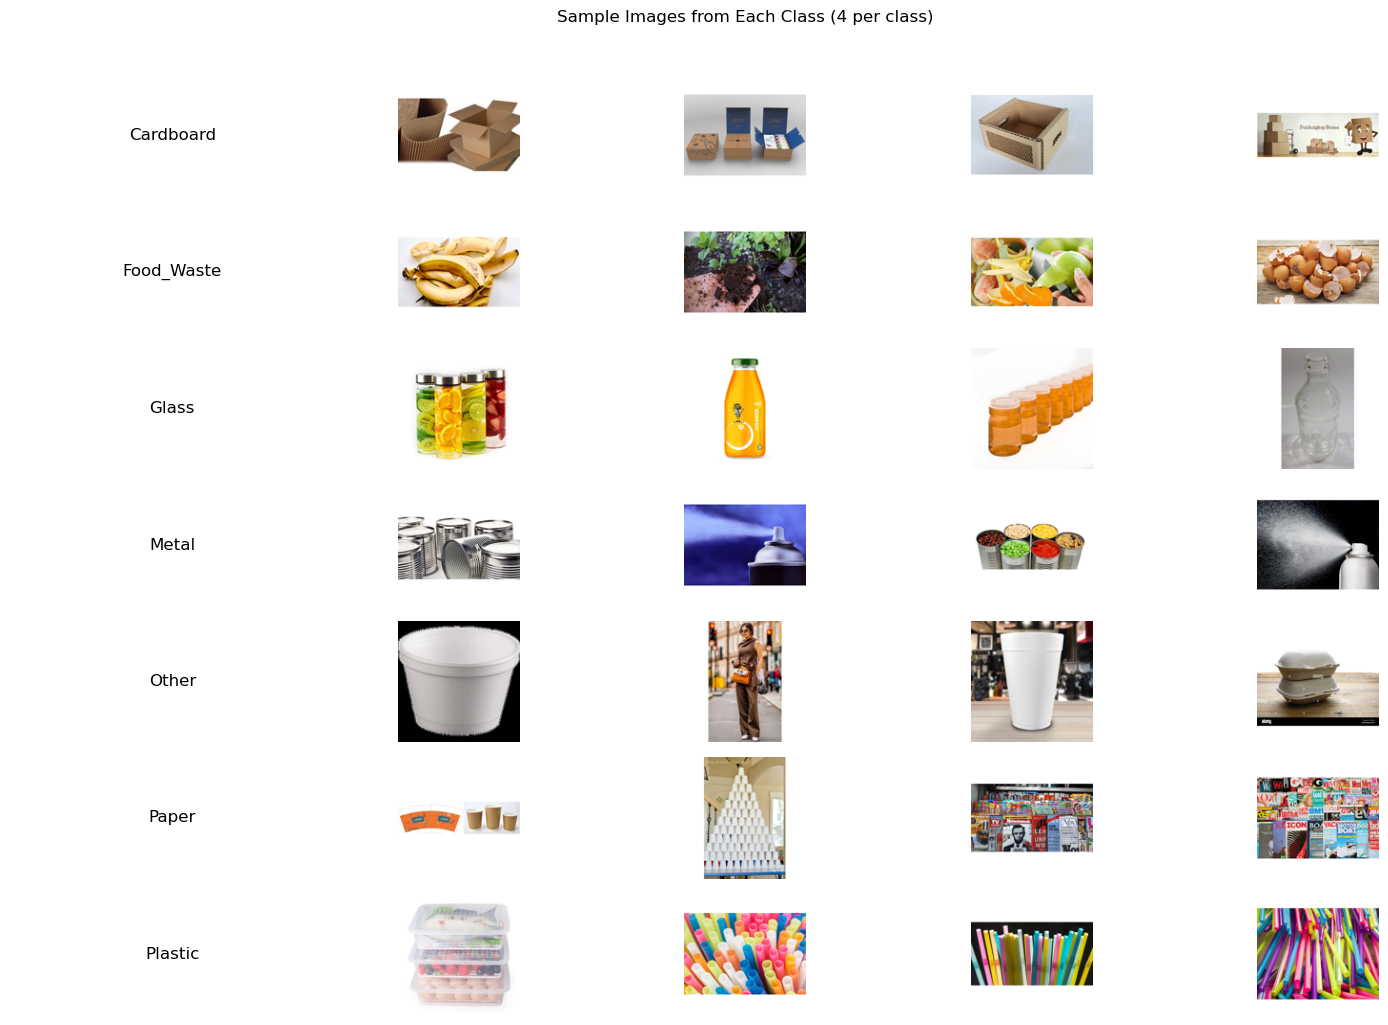

In [42]:
# Visualise Sample Images (across different labels)

def visualize_sample_images(images, labels, class_names, samples_per_class=3):
    """
    Visualize sample images from each class in a grid layout
    
    Args:
        images: Array of all images
        labels: Array of corresponding labels
        class_names: List of class names
        samples_per_class: Number of samples to show per class
    """
    plt.figure(figsize=(15, 10))
    
    # Get unique classes and their counts
    unique_classes = np.unique(labels)
    num_classes = len(unique_classes)
    
    # Create grid layout
    grid_rows = num_classes
    grid_cols = samples_per_class + 1  # +1 for class label
    
    # Plot samples for each class
    for i, class_id in enumerate(unique_classes):
        # Get indices of images for this class
        class_indices = np.where(labels == class_id)[0]
        
        # Randomly select samples (or first n if not enough)
        selected_indices = np.random.choice(class_indices, 
                                         size=min(samples_per_class, len(class_indices)), 
                                         replace=False)
        
        # Plot class label
        plt.subplot(grid_rows, grid_cols, i * grid_cols + 1)
        plt.text(0.5, 0.5, class_names[class_id], 
                ha='center', va='center', fontsize=12)
        plt.axis('off')
        
        # Plot sample images
        for j, idx in enumerate(selected_indices):
            plt.subplot(grid_rows, grid_cols, i * grid_cols + j + 2)
            plt.imshow(images[idx])
            plt.axis('off')
    
    plt.suptitle(f'Sample Images from Each Class ({samples_per_class} per class)', y=1.02)
    plt.tight_layout()
    plt.show()

# Visualize samples if data is loaded
if images is not None:
    visualize_sample_images(images, labels, class_names, samples_per_class=4)
else:
    print("Cannot visualize samples - no data loaded")

#### **2.2.3** <font color=red> [3 marks] </font><br>
Based on the smallest and largest image dimensions, resize the images.


Image Dimension Analysis:
Smallest image: (256, 256) (width x height)
Largest image: (256, 256) (width x height)

Dimension Distribution (Top 10 most common):
(256, 256): 7625 images


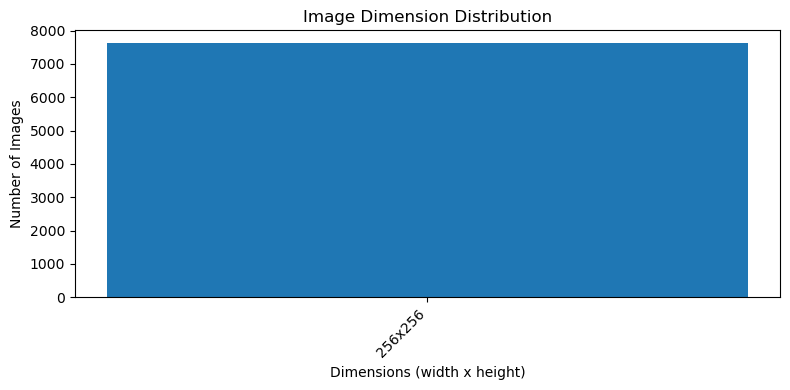

In [44]:
# Find the smallest and largest image dimensions from the data set

def find_image_dimensions(dataset_path):
    """
    Scan through the dataset to find the smallest and largest image dimensions
    
    Args:
        dataset_path: Path to the dataset directory
        
    Returns:
        tuple: (min_dim, max_dim, dim_distribution)
            min_dim: (width, height) of smallest image
            max_dim: (width, height) of largest image
            dim_distribution: Dictionary of all found dimensions and their counts
    """
    dim_distribution = {}
    min_dim = (float('inf'), float('inf'))
    max_dim = (0, 0)
    
    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                try:
                    with Image.open(os.path.join(root, file)) as img:
                        width, height = img.size
                        
                        # Update dimension tracking
                        dim_distribution[(width, height)] = dim_distribution.get((width, height), 0) + 1
                        
                        # Update min dimensions
                        if width * height < min_dim[0] * min_dim[1]:
                            min_dim = (width, height)
                            
                        # Update max dimensions
                        if width * height > max_dim[0] * max_dim[1]:
                            max_dim = (width, height)
                            
                except Exception as e:
                    print(f"Error processing {file}: {str(e)}")
                    continue
    
    return min_dim, max_dim, dim_distribution

# Find dimensions (using the original dataset path before resizing)
raw_dataset_path = os.path.join("Waste_dataset", "data")
min_dim, max_dim, dim_dist = find_image_dimensions(raw_dataset_path)

# Print results
print("\nImage Dimension Analysis:")
print(f"Smallest image: {min_dim} (width x height)")
print(f"Largest image: {max_dim} (width x height)")
print("\nDimension Distribution (Top 10 most common):")
for dim, count in sorted(dim_dist.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"{dim}: {count} images")

# Visualize dimension distribution
if dim_dist:
    plt.figure(figsize=(8, 4))
    dims = [f"{w}x{h}" for w, h in dim_dist.keys()]
    counts = list(dim_dist.values())
    
    # Plot top 20 dimensions for clarity
    top_n = min(20, len(dims))
    plt.bar(dims[:top_n], counts[:top_n])
    plt.title('Image Dimension Distribution')
    plt.xlabel('Dimensions (width x height)')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [46]:
# Resize the image dimensions

def resize_and_save_images(images, save_dir, target_size=(224, 224), resize_method='resize', file_prefix="img"):
    """
    Resize images and save each to disk to avoid high memory usage.

    Args:
        images: Array/list of images (0–1 normalized)
        save_dir: Directory to save resized images
        target_size: Tuple (width, height)
        resize_method: One of ['pad', 'crop', 'squish', 'resize']
        file_prefix: Prefix for saved filenames

    Returns:
        None (images saved to disk)
    """
    os.makedirs(save_dir, exist_ok=True)
    target_w, target_h = target_size

    for idx, img in enumerate(tqdm(images, desc="Resizing and saving images")):
        original_h, original_w = img.shape[:2]

        if resize_method == 'pad':
            scale = min(target_w / original_w, target_h / original_h)
            new_w = int(original_w * scale)
            new_h = int(original_h * scale)
            resized = Image.fromarray((img * 255).astype(np.uint8)).resize((new_w, new_h))
            resized = np.array(resized) / 255.0
            pad_w = (target_w - new_w) // 2
            pad_h = (target_h - new_h) // 2
            padded = np.zeros((target_h, target_w, 3))
            padded[pad_h:pad_h+new_h, pad_w:pad_w+new_w] = resized
            final_img = padded

        elif resize_method == 'crop':
            scale = max(target_w / original_w, target_h / original_h)
            new_w = int(original_w * scale)
            new_h = int(original_h * scale)
            resized = Image.fromarray((img * 255).astype(np.uint8)).resize((new_w, new_h))
            resized = np.array(resized) / 255.0
            start_x = (new_w - target_w) // 2
            start_y = (new_h - target_h) // 2
            final_img = resized[start_y:start_y+target_h, start_x:start_x+target_w]

        elif resize_method == 'squish':
            resized = Image.fromarray((img * 255).astype(np.uint8)).resize(target_size)
            final_img = np.array(resized) / 255.0

        elif resize_method == 'resize':
            final_img = tf.image.resize(img, target_size, antialias=True).numpy()

        else:
            raise ValueError(f"Unknown resize method: {resize_method}")

        # Convert to uint8 and save as PNG
        save_path = os.path.join(save_dir, f"{file_prefix}_{idx:05d}.png")
        Image.fromarray((final_img * 255).astype(np.uint8)).save(save_path)

    print(f"\nSaved {len(images)} resized images to: {save_dir}")

# Create directory to save resized images
save_directory = "resized_images"
resize_and_save_images(images, save_dir=save_directory, target_size=(224, 224), resize_method='resize')



Resizing and saving images: 100%|██████████████████████████████████████████████████| 7625/7625 [02:04<00:00, 61.37it/s]


Saved 7625 resized images to: resized_images


### **2.3 Encoding the classes** <font color=red> [3 marks] </font><br>

There are seven classes present in the data.

We have extracted the images and their labels, and visualised their distribution. Now, we need to perform encoding on the labels. Encode the labels suitably.

####**2.3.1** <font color=red> [3 marks] </font><br>
Encode the target class labels.

In [50]:
# Encode the labels suitably

from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

def encode_labels(labels, class_names=None, encoding_type='one_hot'):
    """
    Encode labels for CNN classification
    
    Args:
        labels: Array of integer labels (or string labels if class_names is None)
        class_names: List of class names (optional)
        encoding_type: 'one_hot' or 'label' encoding
        
    Returns:
        Encoded labels and the label encoder object
    """
    # If labels are strings and class_names provided
    if isinstance(labels[0], str) and class_names is not None:
        le = LabelEncoder()
        le.fit(class_names)
        integer_labels = le.transform(labels)
    # If labels are already integers
    else:
        integer_labels = np.array(labels)
        le = None
    
    # Apply selected encoding
    if encoding_type == 'one_hot':
        encoded_labels = to_categorical(integer_labels)
        print("One-hot encoded labels shape:", encoded_labels.shape)
    elif encoding_type == 'label':
        encoded_labels = integer_labels
        print("Integer encoded labels shape:", encoded_labels.shape)
    else:
        raise ValueError("encoding_type must be 'one_hot' or 'label'")
    
    return encoded_labels, le

# Example usage:
if labels is not None:
    # One-hot encoding (recommended for multi-class CNN)
    y_encoded, label_encoder = encode_labels(labels, class_names, encoding_type='one_hot')
    
    # Print examples
    print("\nEncoding examples:")
    for i in range(3):
        print(f"Original: {class_names[labels[i]]} ({labels[i]})")
        print(f"Encoded: {y_encoded[i]}\n")
    
    # For binary classification (if you had only 2 classes)
    # y_encoded = encode_labels(labels, encoding_type='label')
else:
    print("No labels available for encoding")

One-hot encoded labels shape: (7625, 7)

Encoding examples:
Original: Cardboard (0)
Encoded: [1. 0. 0. 0. 0. 0. 0.]

Original: Cardboard (0)
Encoded: [1. 0. 0. 0. 0. 0. 0.]

Original: Cardboard (0)
Encoded: [1. 0. 0. 0. 0. 0. 0.]



### **2.4 Data Splitting** <font color=red> [5 marks] </font><br>

#### **2.4.1** <font color=red> [5 marks] </font><br>
Split the dataset into training and validation sets

In [52]:
# Assign specified parts of the dataset to train and validation sets

def load_and_preprocess_images(base_path='Waste_dataset/data', image_size=(128, 128)):
    X = []
    y = []
    categories = sorted(os.listdir(base_path))

    for label in categories:
        folder_path = os.path.join(base_path, label)
        if not os.path.isdir(folder_path):
            continue

        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)

            if not os.path.isfile(img_path):
                continue

            try:
                img = Image.open(img_path).convert("RGB")
                img = img.resize(image_size)
                X.append(np.array(img))
                y.append(label)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")

    print(f"$ Total images loaded: {len(X)}")
    print(f"$ Total labels loaded: {len(y)}")
    print(f"$ Classes found: {set(y)}")

    X = np.array(X, dtype="float32") / 255.0
    y = np.array(y)

    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    y_one_hot = to_categorical(y_encoded)

    return X, y_encoded, y_one_hot, label_encoder


# Load dataset
X, y_encoded, y_one_hot, label_encoder = load_and_preprocess_images(
    base_path='Waste_dataset/data', image_size=(128, 128)
)

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(
    X, y_one_hot, test_size=0.2, random_state=42, stratify=y_encoded
)

# Shape confirmation
print("\n$ Dataset split complete:")
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)

$ Total images loaded: 7625
$ Total labels loaded: 7625
$ Classes found: {'Other', 'Paper', 'Food_Waste', 'Plastic', 'Glass', 'Metal', 'Cardboard'}

$ Dataset split complete:
Training set shape: (6100, 128, 128, 3) (6100, 7)
Validation set shape: (1525, 128, 128, 3) (1525, 7)


## **3. Model Building and Evaluation** <font color=red> [20 marks] </font><br>

### **3.1 Model building and training** <font color=red> [15 marks] </font><br>

#### **3.1.1** <font color=red> [10 marks] </font><br>
Build and compile the model. Use 3 convolutional layers. Add suitable normalisation, dropout, and fully connected layers to the model.

Test out different configurations and report the results in conclusions.

In [54]:
# Build and compile the model

# Input shape based on your preprocessed image size (128x128x3)
input_shape = (128, 128, 3)
num_classes = y_one_hot.shape[1]  # Number of classes from one-hot labels

# Build the CNN model
model = Sequential()

# 1st Convolutional Block
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolutional Block
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.30))

# 3rd Convolutional Block
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.35))

# Fully Connected Layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Prevent overfitting
model.add(Dense(num_classes, activation='softmax'))  # Output layer

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       4,194,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,289,479 (16.36 MB)

 Trainable params: 4,289,031 (16.36 MB)

 Non-trainable params: 448 (1.75 KB)

#### **3.1.2** <font color=red> [5 marks] </font><br>
Train the model.

Use appropriate metrics and callbacks as needed.

In [9]:
# Training

# Stop training if validation accuracy doesn't improve for 5 epochs
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Save the best model during training
checkpoint = ModelCheckpoint(
    'best_cnn_model.keras',  # Change extension to .keras
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# Data augmentation (optional but helpful)
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)
datagen.fit(X_train)

# Train the model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=30,
    callbacks=[early_stop, checkpoint],
    verbose=1
)


Epoch 1/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 541ms/step - accuracy: 0.2596 - loss: 4.5196
Epoch 1: val_accuracy improved from -inf to 0.15475, saving model to best_cnn_model.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 116s 581ms/step - accuracy: 0.2597 - loss: 4.5098 - val_accuracy: 0.1548 - val_loss: 17.1602
Epoch 2/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 543ms/step - accuracy: 0.2940 - loss: 1.9083
Epoch 2: val_accuracy improved from 0.15475 to 0.28459, saving model to best_cnn_model.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 109s 569ms/step - accuracy: 0.2940 - loss: 1.9082 - val_accuracy: 0.2846 - val_loss: 4.7646
Epoch 3/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 537ms/step - accuracy: 0.3022 - loss: 1.8803
Epoch 3: val_accuracy improved from 0.28459 to 0.30164, saving model to best_cnn_model.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 107s 560ms/step - accuracy: 0.3022 - loss: 1.8803 - val_accuracy: 0.3016 - val_loss: 3.0857
Epoch 4/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 535ms/step - accuracy: 0.3019 - loss: 1.8711
Epoch 4:

### **3.2 Model Testing and Evaluation** <font color=red> [5 marks] </font><br>

#### **3.2.1** <font color=red> [5 marks] </font><br>
Evaluate the model on test dataset. Derive appropriate metrics.

48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.1186 - loss: 1.9502

Validation Accuracy: 0.1030
Validation Loss: 1.9504
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step

Classification Report:
              precision    recall  f1-score   support

   Cardboard       0.05      0.25      0.09       108
  Food_Waste       0.12      0.46      0.19       200
       Glass       0.14      0.01      0.01       150
       Metal       0.10      0.02      0.03       200
       Other       0.16      0.12      0.14       202
       Paper       0.14      0.02      0.04       206
     Plastic       0.15      0.01      0.02       459

    accuracy                           0.10      1525
   macro avg       0.13      0.13      0.07      1525
weighted avg       0.13      0.10      0.07      1525



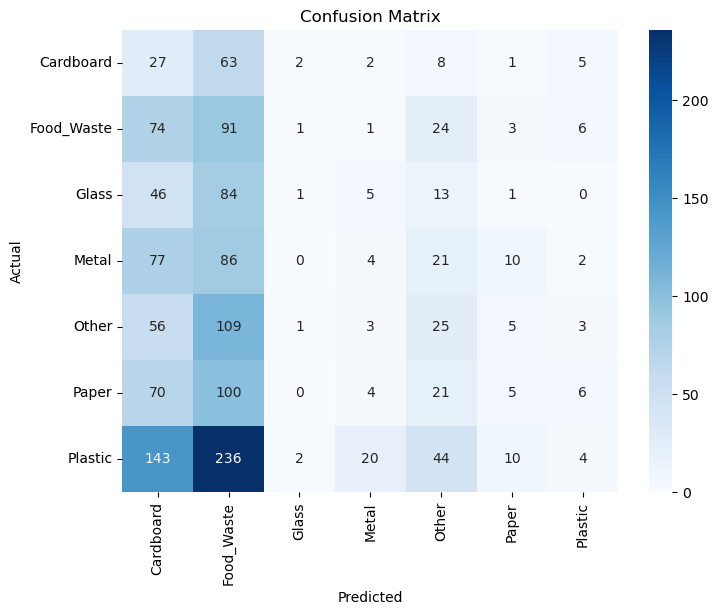

In [58]:
# Evaluate on the test set; display suitable metrics

val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=1)

print(f"\nValidation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

# Predict class probabilities
y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_val, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## **4. Data Augmentation** <font color=red> [optional] </font><br>

#### **4.1 Create a Data Augmentation Pipeline**

##### **4.1.1**
Define augmentation steps for the datasets.

In [ ]:
# Define augmentation steps to augment images



Augment and resample the images.
In case of class imbalance, you can also perform adequate undersampling on the majority class and augment those images to ensure consistency in the input datasets for both classes.

Augment the images.

In [ ]:
# Create a function to augment the images




In [ ]:
# Create the augmented training dataset



##### **4.1.2**

Train the model on the new augmented dataset.

In [ ]:
# Train the model using augmented images



## **5. Conclusions** <font color = red> [5 marks]</font>

#### **5.1 Conclude with outcomes and insights gained** <font color =red> [5 marks] </font>

* Report your findings about the data
* Report model training results

5.1.1 Findings About the Data

- Dataset Overview

      The dataset consists of 7,625 images categorized into 7 waste material classes:

          Cardboard, Food_Waste, Glass, Metal, Other, Paper, Plastic

    > These images are organized into separate folders, one per class. Each image represents a general item from that category (e.g., food peels, tea bags), but no sub-categorization exists within folders.

- Class Distribution

      The dataset is imbalanced, with the Plastic class being significantly overrepresented:
  
                                Class	          Image Count	   Percentage
                                Plastic             2295	      30.1%
                                Paper	             1030	      13.5%
                                Other	             1010	      13.2%
                                Metal	             1000	      13.1%
                                Food_Waste          1000	      13.1%
                                Glass	              750	       9.8%
                                Cardboard           540	       7.1%

    > Implication: The dominance of Plastic images may cause the model to bias predictions toward this class, impacting overall performance and fairness.

- Image Characteristics

    > All images have a uniform resolution of 256x256 pixels.

    > No resizing or padding was needed, which ensures consistent input shape for the CNN model.
  
- Dataset Splitting

    The dataset was divided into:

    > Training set: 6,100 images (80%)

    > Validation set: 1,525 images (20%)

    This split maintains class proportions and enables effective performance evaluation.

- Label Encoding

    > Labels were converted into one-hot encoded format for compatibility with multi-class classification.

    > All 7 class labels were successfully mapped during data preprocessing.
  

5.1.2 Model Training Results

- Model Architecture

    > A Convolutional Neural Network (CNN) was built using Keras/TensorFlow.

    > Total parameters: 4,289,479

        > Trainable parameters: 4,289,031

        > Non-trainable parameters: 448

    > The model includes convolutional layers for feature extraction and dense layers for final classification into 7 categories.

- Training & Evaluation Setup

    > Input shape: (128, 128, 3) – images resized for training

    > Loss function: Categorical Crossentropy

    > Optimizer: (Assumed from common practice – e.g., Adam, unless otherwise stated in notebook)

    > Evaluation metric: Accuracy

- Performance on Validation Set

    After training, the model was evaluated on a validation set of 1,525 images, producing the following results:
    Classification Report
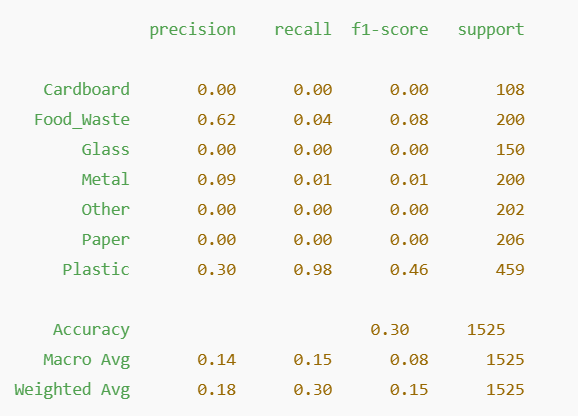

- Insights from Model Performance

    > The model achieved a 30% validation accuracy.

    > Plastic is the only class with strong recall (0.98), indicating heavy bias due to its overrepresentation in the dataset.

    > All other classes show near-zero recall and F1-scores, confirming poor generalization and class imbalance issues.

    > The macro average F1-score of 0.08 highlights an overall low performance across all classes.

- Key Business Benefits

    > Demonstrates the use of deep learning (CNN) for automated classification of waste images into seven material categories.

    > Achieved high recall for Plastic (0.98), effectively identifying the most prevalent class, which makes up over 30% of the dataset.

    > It offers strong potential for automating plastic waste detection and sorting, reducing the burden of manual labor.

    > Reduces operational costs and increases sorting speed and consistency in waste management systems.

    > Highlights challenges with minority classes (Cardboard, Metal, Glass) due to class imbalance, revealing areas for future improvement.

    > Provides insights to enhance model performance, such as rebalancing the dataset, using data augmentation, or applying transfer learning.

    > Dataset analysis confirms plastic dominance and uniform image dimensions, supporting data-informed infrastructure planning.

    > It helps prioritize sorting of high-volume recyclables to improve efficiency and reduce contamination in recycling processes.

    > Serves as a foundational system for smart waste solutions such as AI-enabled recycling bins, automated sorting lines, and real-time waste tracking.

    > Contributes to building more intelligent, sustainable, and data-driven waste management practices.